In [78]:
from pathlib import Path
import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import os
import ntpath

from matplotlib import pyplot as plt

from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate

from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, RMSprop
import argparse
import locale

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from keras import regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import load_model

import datetime

## Data Preparation

Here we combine the csv tables and the raw images and assign all non-covid scans as 'negative' and all covid scans as 'positive'

In [2]:
path = Path('D:\\data_science\\datasets\\coronahack')
sourcepath = path / 'source'
dfpath     = sourcepath / 'covid-chestxray-dataset.csv'

df1 = pd.read_csv(dfpath)
#sort alphabetically by image name - this will ensure the images and metadata are in the same order
df1 = df1.sort_values(by=['filepath'])



In [43]:
# Getting images and reshaping
#remove files not in csv (ie multiple scans of same patient)
keeps = df1['filepath'].apply(lambda x: os.path.splitext(os.path.basename(x))[0]).unique()

for filename in os.listdir(os.path.join(image_folder,'images')):
    if os.path.splitext(filename)[0] not in keeps:
        os.remove(os.path.join(image_folder,'images',filename))
        
image_folder = sourcepath / 'images'
image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        image_folder, shuffle=False, class_mode='binary',
        target_size=(128, 128), batch_size=4)

#reclassify the images in the csv to be covid positive or negative
df1['class'] = np.where(df1['label']=='COVID-19', 1, 0)

Found 156 images belonging to 1 classes.


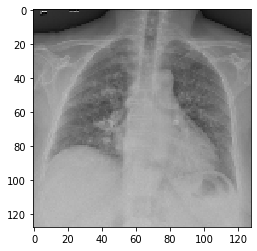

In [54]:
images, labels = next(image_generator)

#plot an image to sensecheck the data generator is feding them in the correct order
plt.imshow(images[0,:,:], cmap='gray')


## Data processing and building the network

In [67]:
from sklearn.preprocessing import MinMaxScaler

def process_structured_data(df, train, test):
    """
    Pre-processes the given dataframe by minmaxscaling the continuous features 
    """
    continuous = ["age"]
    cs = MinMaxScaler()
    trainX = cs.fit_transform(train[continuous])
    testX = cs.transform(test[continuous])
    return (trainX, testX)

def create_mlp(dim, regularizer=None):
    """Creates a simple two-layer MLP with inputs of the given dimension"""
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(4, activation="relu", kernel_regularizer=regularizer))
    return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regularizer=None):
    """
    Creates a CNN with the given input dimension and filter numbers.
    Adapted from the function described here: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
    """
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    inputShape = (height, width, depth)
    chanDim = -1
 
    # Define the model input
    inputs = Input(shape=inputShape)
 
    # Loop over the number of filters 
    for (i, f) in enumerate(filters):
        # If this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
 
        # Create loops of CONV => RELU => BN => POOL layers
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # Final layers - flatten the volume, then Fully-Connected => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
 
    # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
 
    # Construct the CNN
    model = Model(inputs, x)
 
    # Return the CNN
    return model

## Creating a train-test split

In [68]:
from sklearn.model_selection import train_test_split
# Using train_test_split to partition the training and testing structured data attributes and images
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df1, images, test_size=0.25, random_state=57)

# Setting the labels for y as the safe column
trainY = trainAttrX["class"]
testY = testAttrX["class"]

# Process the structured data
(trainAttrX, testAttrX) = process_structured_data(df1, trainAttrX, testAttrX)

## Building the network

In [75]:
# Create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1])
cnn = create_cnn(128, 128, 3)
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

In [76]:
# Add fully connected layers to end of the MLP-CNN combination
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)

model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

## Train the model

In [80]:

start = datetime.datetime.now()

# compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model
model1_history = model1.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX, testImagesX], testY), epochs=50, batch_size=10)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 117 samples, validate on 39 samples
Epoch 1/50
117/117 [==============================] - 4s 35ms/step - loss: 0.7102 - acc: 0.5983 - val_loss: 0.8966 - val_acc: 0.3077
Epoch 2/50
117/117 [==============================] - 3s 25ms/step - loss: 0.6923 - acc: 0.6325 - val_loss: 0.8386 - val_acc: 0.4103
Epoch 3/50
117/117 [==============================] - 3s 24ms/step - loss: 0.6946 - acc: 0.6496 - val_loss: 0.8990 - val_acc: 0.5385
Epoch 4/50
117/117 [==============================] - 3s 24ms/step - loss: 0.6290 - acc: 0.7863 - val_loss: 0.7573 - val_acc: 0.6667
Epoch 5/50
117/117 [==============================] - 3s 24ms/step - loss: 0.6470 - acc: 0.7778 - val_loss: 0.6573 - val_acc: 0.5641
Epoch 6/50
117/117 [==============================] - 3s 24ms/step - loss: 0.6143 - acc: 0.7863 - val_loss: 0.7650 - val_acc: 0.4103
Epoch 7/50
117/117 [==============================] - 3s 27ms/step - loss: 0.5967 - acc: 0.8547 - val_loss: 0.7410 - val_acc: 0.4359
Epoch 8/50
117/117 [====